## MPIOM particle release experiment

**Note**: The original file `UVW_1deg.nc` has been modified by the following commands before loading it into the notebook.

Note that positive vertical velocity is assumed DOWNWARD by `AdvectionRK4_3D`. Since the variable `wo` in the original file was called "upward mass transport", I assumed we need to change the sign to get the correct results.

### Load required packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

# parcels
from datetime import timedelta as delta
from parcels import FieldSet, ParticleSet, JITParticle, ParticleFile, plotTrajectoriesFile
from parcels import AdvectionRK4_3D, ErrorCode

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Define source region

In [2]:
# Define boundaries for source region
south = 53
north = 62
west = -26
east = -10

# Define depth of upper and lower boundary and the number of layers
upper = 30
lower = 500
n_layers = 10

### Define the number of particles to be released in the source region

In [3]:
n = 100

### Define location of each particel

In [4]:
# Construct a 3d mesh of particles in the source region
lons, lats, depths = np.meshgrid(range(west, east), range(south, north),np.linspace(upper, lower, n_layers))

In [5]:
# Randomly pick n particles from the 3d mesh
idxs = np.random.choice(range(len(lons.reshape(-1))),n)
lonp = lons.reshape(-1)[idxs]
latp = lats.reshape(-1)[idxs]
depthp = depths.reshape(-1)[idxs]

#### Alternatively, you can manually define the starting location of each particle

### Define timestep
The timestep at which particles are moved forward (or backward). Positive values of `dt` are for forward trajectories (and negative values are for backward trajectories).

In [6]:
dt = -delta(days=1)

### Set directories

In [7]:
# Define path and name of output file
outfileLabSea = 'mpiom_traj_LabSea.nc'
outfileNFB = 'mpiom_traj_NFB.nc'
outfileENA = 'mpiom_traj_ENA_backward.nc'


outfile = outfileENA

In [8]:
# Define path and name of input file
infile = 'mpiom/mpiom_1x1_new.nc'

### Load hydrodynamic data

In [9]:
variables = {'U': 'uko','V': 'vke','W': 'wo'}
dimensions = {'lon': 'lon', 'lat': 'lat', 'depth': 'depth', 'time': 'time'}

fieldset = FieldSet.from_netcdf(infile, variables, dimensions, allow_time_extrapolation=True, full_load=True)

### Define particle set (`ParticelSet`)

In [10]:
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lonp, lat=latp, depth=depthp)

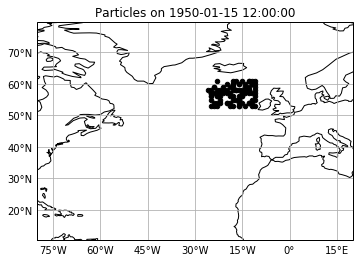

In [11]:
pset.show()

### Run `ParticelSet`

Define `Recovery Kernel` when particles exceed boundary

In [12]:
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()

In [13]:
# Define output
# Note: We store the trajectory information at an interval of 15 days
pfile = ParticleFile(outfile, pset, outputdt=delta(days=15))

In [14]:
# Release particles and simulate advection
pset.execute(AdvectionRK4_3D, runtime=delta(days=2160), dt=dt,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pfile)

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-1000/dcad1ed5e8252b7211d3c96fcf8e4eb1.so


### Check output

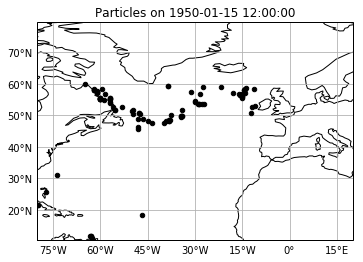

In [15]:
pset.show()

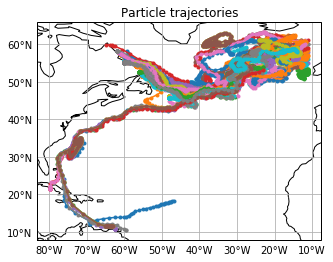

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

In [16]:
# Plot all trajectories
plotTrajectoriesFile(outfile)

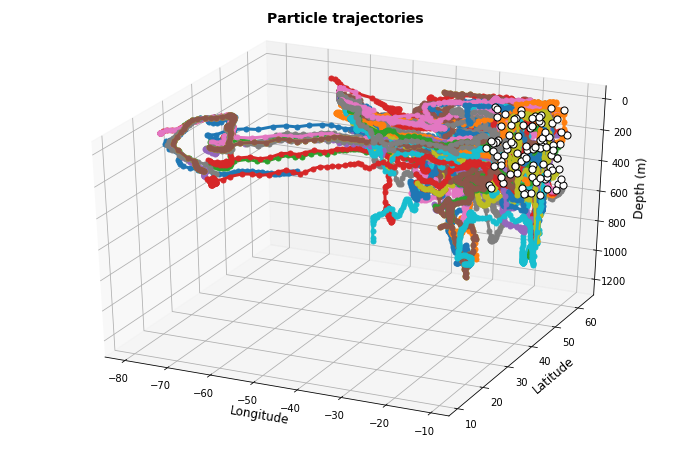

In [17]:
# Plot all trajectories in 3d
traj = xr.open_dataset(outfile,decode_times=False).to_dataframe().reset_index()

plt.figure(figsize=(12,8))

ax = plt.axes(projection='3d')
for tidx in traj.traj.unique():
    trajp = traj[traj.traj==tidx]
    ax.plot(trajp.lon,trajp.lat,trajp.z, linestyle='-', markersize=5, marker='o', linewidth=3)#, alpha=0.5)
    ax.scatter(trajp.lon[:1],trajp.lat[:1],trajp.z[:1],s=50, marker='o',edgecolors='k',facecolors='w')
    
plt.title('Particle trajectories\n',fontsize=14,fontweight='bold')
ax.set_xlabel('Longitude',fontsize=12)
ax.set_ylabel('Latitude',fontsize=12)
ax.set_zlabel('Depth (m)',fontsize=12)

ax.invert_zaxis()
ax.view_init(elev=30., azim=-65)
plt.show()

In [18]:
# Animation
plotTrajectoriesFile(outfile, mode='movie2d_notebook')

### Map trajectories

In [19]:
# Define path and name of figure file (figure will be saved both as .eps and .png)
figure_path = 'mpiom/mpiom_traj'

Each run should be saved in a seperate file. The trajectories can then be loaded into `xarray` datasets and converted to `pandas` data frames.

In [20]:
# Load trajectory files into datasets
trajLabSea = xr.open_dataset(outfileLabSea,decode_times=False).to_dataframe().reset_index()
trajNFB = xr.open_dataset(outfileNFB,decode_times=False).to_dataframe().reset_index()

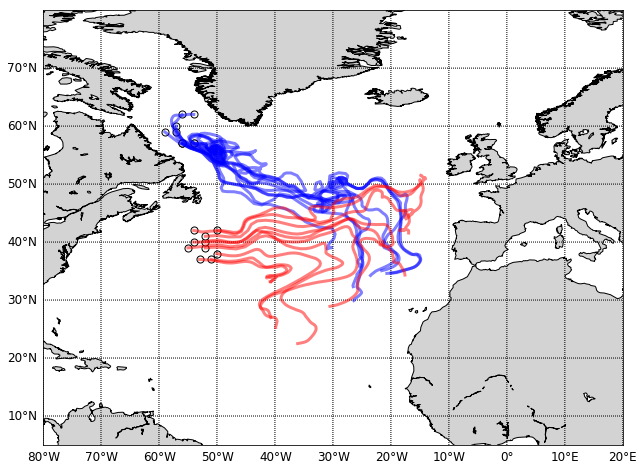

In [21]:
plt.figure(figsize=(12,8))

m = Basemap(projection='cyl',llcrnrlat=5, urcrnrlat=80, llcrnrlon=-80, urcrnrlon=20, 
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-60,80,10),labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10),labels=[0,0,0,1],fontsize=12)

ax = plt.gca()
for tidx in trajLabSea.traj.unique():
    traj = trajLabSea[trajLabSea.traj==tidx]
    ax.plot(traj.lon,traj.lat, linestyle='-',markersize=5, linewidth=3, alpha=0.5, c='blue')
    ax.scatter(traj.lon[:1],traj.lat[:1],s=50,marker='o',edgecolors='black',facecolors='w')

for tidx in trajNFB.traj.unique():
    traj = trajNFB[trajNFB.traj==tidx]
    ax.plot(traj.lon,traj.lat, linestyle='-',markersize=5, linewidth=3, alpha=0.5, c='red')
    ax.scatter(traj.lon[:1],traj.lat[:1],s=50,marker='o',edgecolors='black',facecolors='w')

plt.savefig(figure_path+'.png')
plt.savefig(figure_path+'.eps')
plt.show()

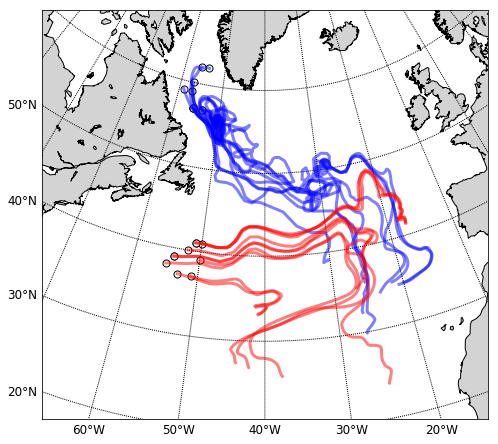

In [21]:
plt.figure(figsize=(8,8))

m = Basemap(width=6000000,height=5500000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=45.,lat_2=55,lat_0=45,lon_0=-40.)

m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-60,80,10),labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10),labels=[0,0,0,1],fontsize=12)

ax = plt.gca()
for tidx in trajLabSea.traj.unique():
    traj = trajLabSea[trajLabSea.traj==tidx]
    lon, lat = m(list(traj.lon),list(traj.lat))
    m.plot(lon, lat, linestyle='-',markersize=5, linewidth=3, alpha=0.5, c='b')
    m.scatter(lon[:1],lat[:1],s=50, marker='o',edgecolors='k',facecolors='w')

for tidx in trajNFB.traj.unique():
    traj = trajNFB[trajNFB.traj==tidx]
    lon, lat = m(list(traj.lon),list(traj.lat))
    m.plot(lon, lat, linestyle='-',markersize=5, linewidth=3, alpha=0.5, c='r')
    m.scatter(lon[:1],lat[:1],s=50, marker='o',edgecolors='k',facecolors='w')

plt.savefig(figure_path+'.png')
plt.savefig(figure_path+'.eps')
plt.show()